<a href="https://colab.research.google.com/github/ishikaww/SIH-plankton/blob/main/Efficient_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Remove conflicting preinstalled versions
!pip uninstall -y tensorflow tensorflow-cpu tensorflow-intel numpy

# Install stable versions that are compatible
!pip install tensorflow==2.17.1 numpy==1.26.4 roboflow


Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.4/601.4 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 133.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 135.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
     

In [ ]:
import numpy as np
import tensorflow as tf

print("✅ NumPy version:", np.__version__)
print("✅ TensorFlow version:", tf.__version__)
print("✅ GPUs found:", tf.config.list_physical_devices('GPU'))


✅ NumPy version: 2.0.2
✅ TensorFlow version: 2.19.0
✅ GPUs found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!pip install fastai

In [ ]:
from fastai.vision import *

In [ ]:
!pip install roboflow

In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key="gfPvlcLH3epGBoxMjbwE")
project = rf.workspace("dehydratedaf").project("carbonate-image-classification-tkhgt")
dataset = project.version(1).download("folder")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Carbonate-Image-Classification-1 in folder:: 100%|██████████| 3415/3415 [00:00<00:00, 7826.69it/s]


In [ ]:
dataset.location

'/content/Carbonate-Image-Classification-1'

In [ ]:
train_dir = "/content/Carbonate-Image-Classification-1/train"
val_dir = "/content/Carbonate-Image-Classification-1/valid"
test_dir = "/content/Carbonate-Image-Classification-1/test"

In [ ]:
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Dataset path (Roboflow download location)
path = Path(dataset.location)

# EfficientNetB0 default input size = 224 (faster than 256)
IMG_SIZE = 224
BATCH_SIZE = 32

# Strong augmentation (similar to fastai's aug_transforms)
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=25,          # max_rotate=25
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,            # max_warp-like
    zoom_range=0.2,             # max_zoom=1.2
    horizontal_flip=True,       # do_flip
    vertical_flip=True,         # flip_vert
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Train/Valid/Test loaders
train_generator = train_datagen.flow_from_directory(
    path / "train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    path / "valid",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    path / "test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Classes (similar to fastai's data.vocab)
classes = list(train_generator.class_indices.keys())
print("Classes:", classes)

NUM_CLASSES = len(classes)


Found 2917 images belonging to 15 classes.
Found 294 images belonging to 15 classes.
Found 154 images belonging to 15 classes.
Classes: ['benthic foraminifera', 'bivalve', 'brachiopod', 'bryozoan', 'cephalopod', 'crinoid', 'echinoid', 'gastropod', 'green algae', 'ostracod', 'plankton foraminifera', 'red algae', 'rugose coral', 'scleractinian coral', 'sponges']


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

# --- Base model (pretrained on ImageNet, no top classifier)
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# --- Freeze all layers first
for layer in base_model.layers:
    layer.trainable = False

# --- Unfreeze last 20 layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# --- Custom classification head (like fastai's head)
x = GlobalAveragePooling2D(name="avg_pool")(base_model.output)
x = Dense(256, activation="relu",
          kernel_regularizer=tf.keras.regularizers.l2(0.001),
          name="dense_head")(x)
x = Dropout(0.4, name="dropout_head")(x)
outputs = Dense(NUM_CLASSES, activation="softmax", name="predictions")(x)

# --- Full model
model = Model(inputs=base_model.input, outputs=outputs, name="EfficientNetB0_fine_tune")

# --- Optimizer (SGD with momentum, stable for fine-tuning)
optimizer = SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)

# --- Compile model
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

print("✅ EfficientNetB0 model ready")
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
✅ EfficientNetB0 model ready


Model: "EfficientNetB0_fine_tune"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,381,362 (16.71 MB)

 Trainable params: 1,682,751 (6.42 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- Callbacks
early_stop = EarlyStopping(
    monitor="val_loss", patience=7, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.3, patience=3, min_lr=1e-6, verbose=1
)

callbacks = [early_stop, reduce_lr]

# --- Training
EPOCHS = 30

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks
)


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 101s 765ms/step - accuracy: 0.1015 - loss: 3.1677 - val_accuracy: 0.1497 - val_loss: 3.0089 - learning_rate: 0.0010
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 388ms/step - accuracy: 0.1900 - loss: 2.9490 - val_accuracy: 0.2007 - val_loss: 2.8628 - learning_rate: 0.0010
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 392ms/step - accuracy: 0.2665 - loss: 2.7646 - val_accuracy: 0.2585 - val_loss: 2.7260 - learning_rate: 0.0010
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 387ms/step - accuracy: 0.3440 - loss: 2.5934 - val_accuracy: 0.3129 - val_loss: 2.6002 - learning_rate: 0.0010
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 393ms/step - accuracy: 0.3834 - loss: 2.4582 - val_accuracy: 0.3537 - val_loss: 2.4842 - learning_rate: 0.0010
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 394ms/step - accuracy: 0.4193 - loss: 2.3260 - val_accuracy: 0.3878 - val_loss: 2.3782 - learning_rate: 0.0010
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 389ms/step - accuracy: 0.4509 - loss: 2

In [ ]:
# Save full model (architecture + weights + optimizer state)
model.save("efficientnetb0_best.h5")

print("✅ Model saved as efficientnetb0_best.h5")


✅ Model saved as efficientnetb0_best.h5


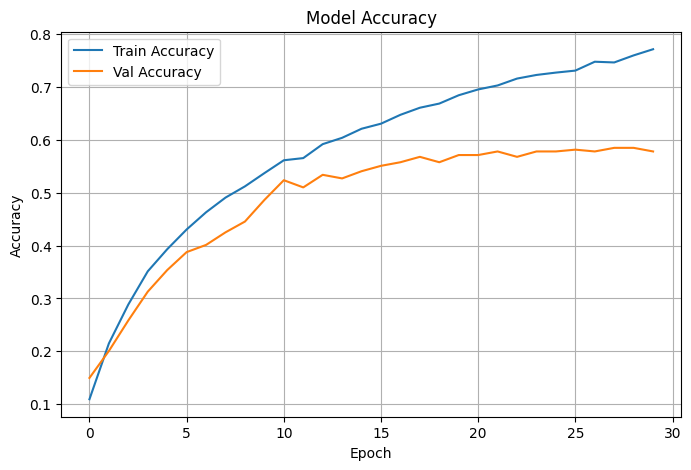

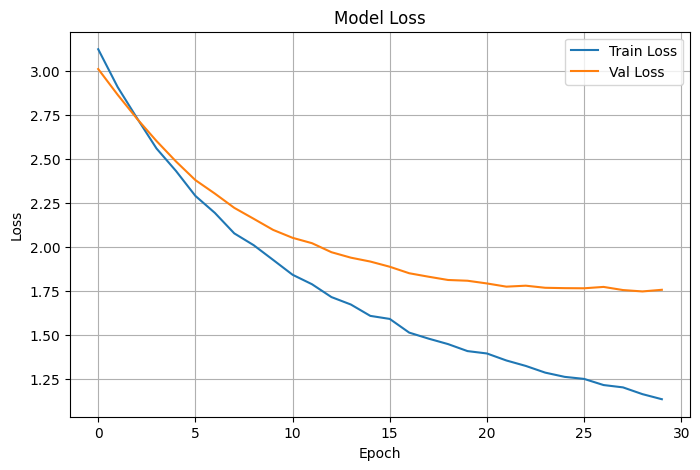

In [ ]:
import matplotlib.pyplot as plt

# --- Accuracy curve
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# --- Loss curve
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.4761 - loss: 1.9219
✅ Test Accuracy: 50.00%
✅ Test Loss: 1.9120
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step

Classification Report:

                       precision    recall  f1-score   support

 benthic foraminifera       0.33      0.22      0.27         9
              bivalve       0.33      0.38      0.35         8
           brachiopod       0.82      0.53      0.64        17
             bryozoan       0.75      0.90      0.82        10
           cephalopod       0.36      0.50      0.42         8
              crinoid       0.14      0.17      0.15         6
             echinoid       0.25      0.08      0.12        12
            gastropod       0.70      0.78      0.74        18
          green algae       0.57      0.44      0.50         9
             ostracod       0.45      0.62      0.53         8
plankton foraminifera       0.56      0.69      0.62        13
            red algae       0.60      0.60      0.60        10
   

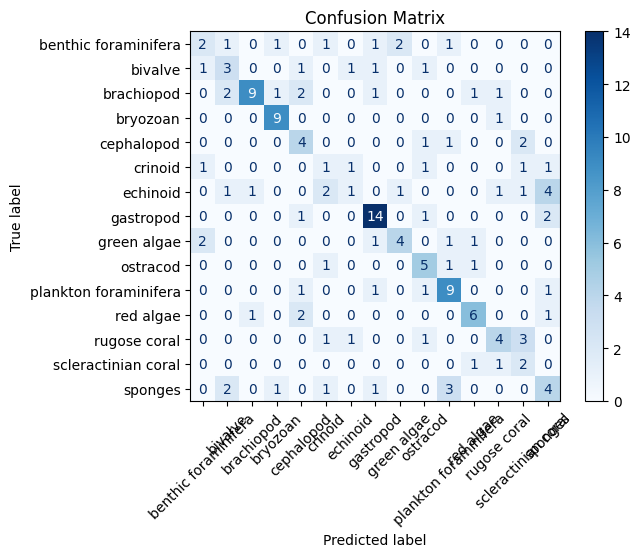

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Evaluate overall test performance
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"✅ Test Loss: {test_loss:.4f}")

# --- Predictions
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)
class_labels = list(test_generator.class_indices.keys())

# --- Classification report (precision, recall, f1 per class)
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# --- Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(xticks_rotation=45, cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Total misclassified: 77 / 154


ValueError: Asked to retrieve element 5, but the Sequence has length 5

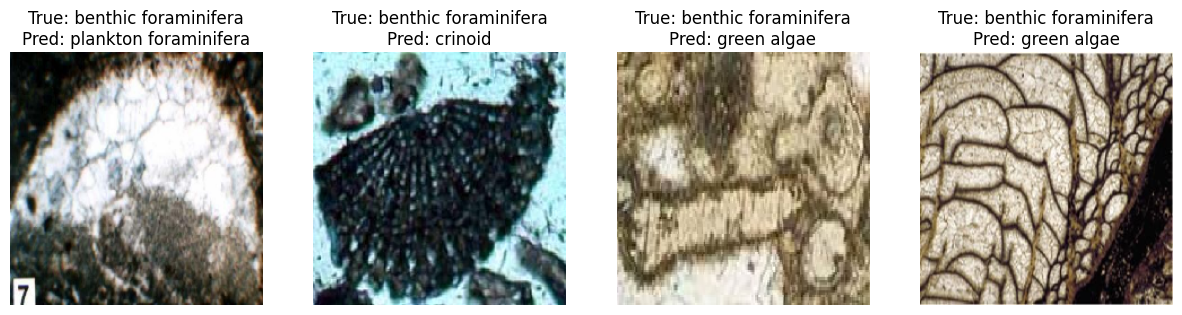

In [ ]:
import matplotlib.pyplot as plt

# --- Get predictions
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)
class_labels = list(test_generator.class_indices.keys())

# --- Find misclassified indexes
misclassified_idx = np.where(y_true != y_pred)[0]

print(f"Total misclassified: {len(misclassified_idx)} / {len(y_true)}")

# --- Show some misclassified samples
n_show = 12
plt.figure(figsize=(15, 12))
for i, idx in enumerate(misclassified_idx[:n_show]):
    img, label = test_generator[idx]  # batch-style indexing
    plt.subplot(3, 4, i+1)
    plt.imshow(img[0].astype("uint8"))
    plt.title(f"True: {class_labels[y_true[idx]]}\nPred: {class_labels[y_pred[idx]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()
